# Adapted Attribute Types

DataJoint 0.12+ allows storing arbitrary combinations of basic Python types in blobs.  `dj.AttributeAdapter` is a new experimental feature that allows storing more complex objects. Since it's experimental, it's not yet included in the main documentation. To enable it, please set the environment variable `DJ_SUPPORT_ADAPTED_TYPES` to `"TRUE"`:

In [1]:
# enable the use of adapted types for this session
import os
os.environ['DJ_SUPPORT_ADAPTED_TYPES'] = "TRUE"  

Once the feature graduates from its experimental phase, in a future release, the environment variable will no longer need to be set.

In [2]:
# Show author, date, and version
import datetime, getpass
print(getpass.getuser(), datetime.datetime.today())

import datajoint as dj
print('DataJoint Version', dj.__version__)

dimitri 2019-11-03 19:04:28.827158
DataJoint Version 0.12.1


In this example, we will store objects of type `Graph` from the `networkx` (https://networkx.github.io/). 

First, let's create a few graphs:

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
graphs = [nx.lollipop_graph(4, 2), nx.star_graph(5), nx.barbell_graph(3, 1), nx.cycle_graph(5)]

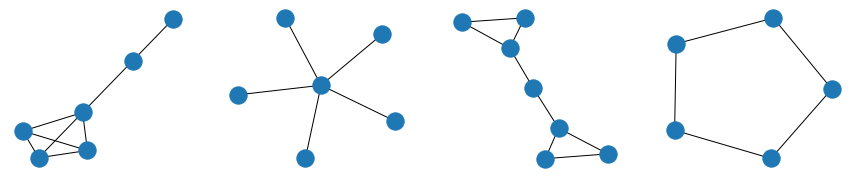

In [5]:
fig, axx = plt.subplots(1, len(graphs) , figsize=(15, 3))

for g, ax in zip(graphs, axx.flatten()):
    plt.sca(ax)
    nx.draw(g)

Then we need to define an adapter object that convert target objects into an attribute type that datajoint can already store. The class must subclass `dj.AttributeAdapter` and define the property `attribute_type`, and methods `get` and `put`. These methods translate the adapted data type `nx.Graph` into a representation that can be stored in datajoint, a `longblob` storing the edge list.

In [6]:
import datajoint as dj
dj.config["enable_python_native_blobs"] = True  # enable Python types in blobs 

class GraphAdapter(dj.AttributeAdapter):
    
    attribute_type = 'longblob'   # this is how the attribute will be declared
    
    def put(self, obj):
        # convert the nx.Graph object  into an edge list
        assert isinstance(obj, nx.Graph)
        return list(obj.edges)

    def get(self, value):
        # convert edge list back into an nx.Graph
        return nx.Graph(value)
    

# instantiate for use as a datajoint type
graph = GraphAdapter()

Now we can define a table that uses `graph` as its attribute type. These "adapted types" must be enclosed in angle brackets as in `<graph>`:

In [7]:
schema = dj.schema('test_graphs')

Connecting dimitri@localhost:3306


In [8]:
@schema
class Connectivity(dj.Manual):
    definition = """
    conn_id : int
    ---
    conn_graph = null : <graph>  # a networkx.Graph object 
    """

In [9]:
Connectivity.delete()  #  clean up from previous run

About to delete:
Nothing to delete


In [10]:
Connectivity.describe();

conn_id              : int                          
---
conn_graph=null      : <graph>                      # a networkx.Graph object



### Now, populate the table with our example graphs and fetch them as objects
Inserting the graphs as objects

In [11]:
Connectivity.insert((i, g) for i, g in enumerate(graphs))

We can now fetch the graphs as an array of objects and plot them to verify successful recovery.

In [12]:
result = Connectivity.fetch('conn_graph', order_by='conn_id')

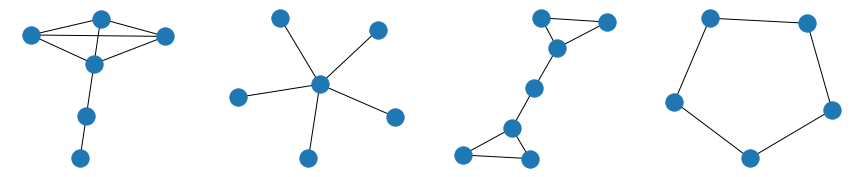

In [14]:
fig, axx = plt.subplots(1, result.size, figsize=(15, 3))
for g, ax in zip(result, axx.flatten()):
    plt.sca(ax)
    nx.draw(g)

That's all!